In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
### DEFINE USEFUL FUNCTIONS

def fk(x, Ap):
    "A useful function"
    fk = 0.2*x**5 * (1 + 5/7*(2+4*Ap)*x**2 + 5/9 * (3 + 10*Ap + 4*Ap**2)*x**4)
    return fk

def fgam(x, rc, Lp, Ap):
    "Annother useful function"
    D = (rc/Lp)**2 * (1-0.3*(rc/Lp)**2)
    fgam = x**3 * (-D/3 + ((1+D)/5)*x**2 + ((Ap*D-1.3)/7)*x**4)
    return fgam

def fchi(x, ri, Lp):
    "Yet annother useful function"
    fchi = x**3 * (-1/3*(ri/Lp)**2 + 0.2*(1+(ri/Lp)**2)*x**2 - 13/70*x**4)
    return fchi

def fc(x, delta, Ap):
    "The last useful function, for now"
    fc = x**3 * (1 - 0.6*(delta+1)*x**2 - 3/14*(delta+1)*(2*Ap-delta)*x**4)
    return fc

def runEarthModel(Qbmo0, QbmoNow, H0M, h, TC, core_Kppm, Ppc):
    ### DEFINE CONSTANTS

    ## Fundamental
    mu0 = 4e-7 * np.pi  # Vacuum pearmeability (SI)
    G = 6.67e-11        # Gravitational constant (SI)
    y2s = 3.154e7       # Seconds per Earth year 
    R = 8.3145          # Universal gas constant (J/K/mol)

    ## Planet
    rp = 6371e3     # Radius of the planet (m)

    ## Core
    ri = 0           # Radius of the inner core (m)
    rc = 3480e3                                # Radius of the core (m)
    kc = 40                                    # Thermal conductivity (W/m/K)
    K0 = 1403e9                                # Effective modulus (Pa)
    K1 = 3.567                                 # Effective derivative of effective modulus 
    rho0 = 12451                               # Central density (kg/m^3)
    Lp = np.sqrt(3*K0/(2*np.pi*G*rho0**2))     # Length scale (m)
    Ap = 0.1*(5*K1-13)                         # Constant in density profile
    Pc = 125e9                                 # Pressure at the core/mantle boundary (Pa)
    P0 = Pc + K0*((rc/Lp)**2 + 0.8*(rc/Lp)**4) # Central pressure (Pa)
    Cc = 750        # Specific heat of the core (J/kg/K)     
    bet = 0.83      # Coefficient of compositional expansion for inner core
    alp = 0.8       # Coefficient of compositional expansion for magnesium precipitation
    dTLdc = -21e-3  # Compositional dependence of liquidus temperature (K)
    dTLdP = 9e-9    # Pressure dependence of liquidus temperature (K/Pa)
    c0 = 0.056      # Initial mass fraction of light elements
    gamm = 1.5      # Gruneisen parameter
    TL0 = 5806      # Liquidus temperature at the center (K)
    DSc = 127       # Entropy of melting (J/K/kg)
    TcIC = TL0*(1 - (rc/Lp)**2 - Ap*(rc/Lp)**4)**gamm;  # T @ CMB when IC nucleates (K)
    Mc = 4/3*np.pi*rho0*Lp**3*fc(rc/Lp, 0, Ap);         # Mass of the core (kg)
    g = 4/3*np.pi*G*rho0*rc*(1-0.6*(rc/Lp)**2 - 3/7*Ap*(rc/Lp)**4) # Gravitational acceleration near the CMB (m/s^2)
    HlamC = 1.76e-17 # Average decay constant (1/s)
    h0C = 4.1834e-14 # Heating per unit mass per ppm of K in the core (W/kg/ppm)

    ## Basal Magma Ocean (BMO)
    DSm = 300       # Entropy of melting (J/K/kg) =652 in Stixrude et al. but =300 in Labrosse et al.
    rhoM = 5500     # Density of the basal mantle (kg/m^3)
    Cm = 1000       # Specific heat of the basal mantle (J/kg/K)
    Dphi = 0.088    # Mass fraction change of FeO-rich component upon freezing 
    TA = 5500       # Melt temperature of the MgO-rich component (K)
    TB = 3500       # Melt temperature of the FeO-rich component (K)
    alphT = 1.25e-5             # Coefficient of thermal expansion in the BMO (1/K)
    OmegaE = 2*np.pi/(24*3600)  # Rotation rate of Earth
    HT = Cm/(alphT*g)           # Thermal scale height for the BMO (m)
    sigBMO = 2e4                # Electrical conductivity of the BMO (S/M)
    c = 0.63                    # Constant prefactor in the scaling law for B-field strength
    fohm = 0.9                  # Fraction of available power converted into magnetic field energy
    HlamM = 1.38e-17   # Average decay constant (1/s)
    rb = rc + h      # Initial radius of BMO (m)

    ### RUN THE MODEL

    ## Define timesteps
    NN = 9000             # Number of timesteps
    tend = 4.5e9 * y2s   # Duration of model (s)
    dt = tend/(NN-1)     # Duration of timestep (s)

    t_all = np.linspace(0,tend,NN)

    # Create empty arrays to store parameters
    rb_all = np.zeros(NN)  # Radius of the BMO upper boundary (m)
    ri_all = np.zeros(NN)  # Radius of the inner core (m)

    TM_all = np.zeros(NN)  # Temperature of the solid mantle (K)
    TC_all = np.zeros(NN)  # Temperature of the BMO and core (K)
    TLi_all = np.zeros(NN) # Temperature at the inner core boundary (K)

    Qsm_all = np.zeros(NN)   # Secular cooling of the BMO (W)
    Qlm_all = np.zeros(NN)   # Latent heat in the BMO (W)

    Qsc_all = np.zeros(NN) # Secular cooling of the core (W)
    Qpc_all = np.zeros(NN) # Precipitation of light elements from the core (W)
    Qgc_all = np.zeros(NN) # Gravitational energy from inner core growth (W)
    Qlc_all = np.zeros(NN) # Latent heat from inner core growth (W)
    Qic_all = np.zeros(NN) # Conductive cooling of the inner core (W)

    # Initialize radiogenic heating and the heat flow into the solid mantle
    Qbmo_all = np.linspace(Qbmo0,QbmoNow,NN)        # Heat flow into the base of the solid mantle (W)
    Qrm_all = H0M*np.exp(-HlamM*t_all)              # Radiogenic heat in the BMO (W)
    Qrc_all = Mc*h0C*core_Kppm*np.exp(-HlamC*t_all) # Radiogenic heating in the core (W)

    ## Begin the time loop
    for ii, t in enumerate(t_all):
        # Calculate heat flow out of the BMO
        Qbmo = Qbmo_all[ii]
    
        # Calculate radiogenic heating in the BMO and core
        Qrm = Qrm_all[ii]
        Qrc = Qrc_all[ii]
    
        # Calculate proportionalities for BMO
        Mm = (4/3)*np.pi*(rb**3-rc**3)*rhoM               # Mass of the BMO (kg)
        BigTerm = (rb**3-rc**3)/(3*rb**2*Dphi*(TA-TB))    # Gather some constants...
    
        Qsm_til = -Mm*Cm
        Qlm_til = -4*np.pi*rb**2*DSm*rhoM*TC*BigTerm

        # Calculate proportionalities for core
        Qpc_til = 8/3*(np.pi**2*G*rho0**2*Lp**5*alp*Ppc *
                       (fgam(rc/Lp,rc,Lp,Ap) - fgam(ri/Lp,rc,Lp,Ap)))

        if TC > TcIC:    # No inner core!
            Qsc_til = -4/3*(np.pi*rho0*Cc*Lp**3 * fc(rc/Lp, gamm, Ap) * 
                            (1-(rc/Lp)**2 - Ap*(rc/Lp)**4)**(-gamm)) 
            Qgc_til = 0
            Qlc_til = 0
            Qic_til = 0
        
            dridt = 0
            TLi = TL0
        else:            # Yes inner core!
            if ri < 2e4:
                ri = 2e4  # Avoid dividing by zero (even once...)
            
            Mic = Mc - 4/3*np.pi*rho0*Lp**3*(fc(rc/Lp,0,Ap) - fc(ri/Lp,0,Ap))
            TLi = TL0 - (K0*dTLdP*(ri/Lp)**2 + dTLdc*c0*ri**3/(Lp**3*fc(rc/Lp,0,Ap)))
            dTLdri = -2*(K0*dTLdP*ri/Lp**2 + (3*dTLdc*c0*ri**2 / (Lp**3*fc(rc/Lp,0,Ap))))
            rhoi = rho0 * (1 -(ri/Lp)**2 - Ap*(ri/Lp)**4)
            gi = 4/3*np.pi*G*rho0*ri*(1-0.6*(ri/Lp)**2 - 3/7*Ap*(ri/Lp)**4)
            dTadP = gamm*TLi/K0
        
            dridTC = -(1/(dTLdP-dTadP)) * TLi/(TC*rhoi*gi)
        
            Psc = (-4/3*np.pi*rho0*Cc*Lp**3 *  
                   (1-(ri/Lp)**2-Ap*(ri/Lp)**4)**(-gamm) * 
                   (dTLdri+2*gamm*TLi*ri/Lp**2 *
                    (1+2*Ap*(ri/Lp)**2)/(1-(ri/Lp)**2-Ap*(ri/Lp)**4)) *  
                   (fc(rc/Lp, gamm, Ap) - fc(ri/Lp, gamm, Ap)))
            Pgc = (8*np.pi**2*c0*G*rho0**2*bet*ri**2*Lp**2 / fc(rc/Lp,0,Ap) *
                   (fchi(rc/Lp,ri,Lp) - fchi(ri/Lp,ri,Lp)))
            Plc = 4*np.pi*ri**2*rhoi*TLi*DSc
            Pic = Cc*Mic*dTLdP*K0*(2*ri/Lp**2 + 3.2*ri/Lp**5)
        
            Qsc_til = Psc * dridTC
            Qgc_til = Pgc * dridTC
            Qlc_til = Plc * dridTC
            Qic_til = Pic * dridTC
        
        
        # Calculate cooling rate
        dTCdt = (Qbmo - Qrm - Qrc)/(Qsm_til + Qlm_til + Qsc_til + Qpc_til + Qgc_til + Qlc_til + Qic_til)
        drbdt = BigTerm*dTCdt
        if TC < TcIC:
            dridt = dridTC * dTCdt
        else:
            dridt = 0
            
        # Calculate all energetic terms
        Qsm = Qsm_til * dTCdt
        Qlm = Qlm_til * dTCdt
    
        Qsc = Qsc_til * dTCdt
        Qpc = Qpc_til * dTCdt
        Qgc = Qgc_til * dTCdt
        Qlc = Qlc_til * dTCdt
        Qic = Qic_til * dTCdt
    
        # Store output
        rb_all[ii] = rb
        ri_all[ii] = ri
        TC_all[ii] = TC
        TLi_all[ii] = TLi
    
        Qbmo_all[ii] = Qbmo
        Qsm_all[ii] = Qsm
        Qlm_all[ii] = Qlm
    
        Qsc_all[ii] = Qsc
        Qpc_all[ii] = Qpc
        Qgc_all[ii] = Qgc
        Qlc_all[ii] = Qlc
        Qic_all[ii] = Qic
    
        # Advance parameters one step
        TC = TC + dTCdt*dt
        rb = rb + drbdt*dt
        ri = ri + dridt*dt
    
    
    ### POST-PROCESSING

    ## Dynamo in BMO?

    # Flow velocities
    h_all = rb_all - rc
    qsm = Qbmo_all/(4*np.pi*rb_all**2)

    v_mix = (h_all*qsm/(rhoM*HT))**(1/3)                   # Mixing length theory
    v_CIA = (qsm/(rhoM*HT))**(2/5) * (h_all/OmegaE)**(1/5) # CIA balance
    v_MAC = (qsm/(rhoM*OmegaE*HT))**(1/2)                  # MAC balance

    # Magnetic Reynolds numbers
    Rm_mix = mu0*sigBMO*h_all*v_mix
    Rm_CIA = mu0*sigBMO*h_all*v_CIA
    Rm_MAC = mu0*sigBMO*h_all*v_MAC

    # Magnetic field strength at the BMO
    Bm_mix = np.sqrt(2*mu0*fohm*c*rhoM*v_mix**2)
    Bm_CIA = np.sqrt(2*mu0*fohm*c*rhoM*v_CIA**2)
    Bm_MAC = np.sqrt(2*mu0*fohm*c*rhoM*v_MAC**2)

    # Magnetic field strength at the surface
    Bs_mix = 1/7*Bm_mix*(rb_all/rp)**3
    Bs_CIA = 1/7*Bm_CIA*(rb_all/rp)**3
    Bs_MAC = 1/7*Bm_MAC*(rb_all/rp)**3

    ## Dynamo in core?
    EK_all = 16*np.pi*gamm**2*kc*Lp*(fk(rc/Lp,Ap)-fk(ri_all/Lp,Ap))

    Tbot_all = np.zeros(NN)
    for ii, ri in enumerate(ri_all):
        if ri > 0:
            Tbot_all[ii] = TLi_all[ii]
        else:
            Tbot_all[ii] = TC_all[ii]*(1-(rc/Lp)**2 - Ap*(rc/Lp)**4)**(-gamm)

    TS_all = Tbot_all*((1-(ri_all/Lp)**2-Ap*(ri_all/Lp)**4)**(-gamm) * 
                      (fc(rc/Lp,gamm,Ap) - fc(ri_all/Lp,gamm,Ap)) / 
                      (fc(rc/Lp,0,Ap) - fc(ri_all/Lp,0,Ap)))
    Tdis = ((Tbot_all / (1 - (ri_all/Lp)**2 - Ap*(ri_all/Lp)**4)**gamm) *
            ((fc(rc/Lp,0,Ap) - fc(ri_all/Lp,0,Ap)) / (fc(rc/Lp,-gamm,Ap) - fc(ri_all/Lp,-gamm,Ap))))

    Plc_all = (Tdis*(TLi_all-TC_all)/(TLi_all*TC_all))*Qlc_all
    Pic_all = (Tdis*(TLi_all-TC_all)/(TLi_all*TC_all))*Qic_all
    Pgc_all = (Tdis/TC_all)*Qgc_all

    Qcc_all = Qsc_all + Qpc_all + Qgc_all + Qlc_all + Qic_all

    Prc_all = ((Tdis-TC_all)/TC_all)*Qrc_all
    Psc_all = (Tdis*(TS_all-TC_all)/(TS_all*TC_all))*Qsc_all
    Ppc_all = (Tdis/TC_all)*Qpc_all
    Pk_all = Tdis*EK_all

    P_inner = Plc_all + Pic_all + Pgc_all
    P_outer = Prc_all + Psc_all + Ppc_all - Pk_all
    Vc = 4/3*np.pi*(rc-ri_all)**3  # Volume of the core (m^3)
    rho_av = Mc/Vc        # Average density of the core (kg/m^3)
    D_all = rc-ri_all     # Thickness of the outer core (m)
    phi_outer = rc*g/2              # Gravitational potential at the CMB (m^2/s^2)
    phi_inner = ri_all**2/rc * g/2  # Gravitational potential at the inner core boundary (m^2/s^2)
    phi_mean = 0.3*g/rc*((rc**5-ri_all**5)/(rc**3-ri_all**3)) # Average grav. potential in the outer core (m^2/s^2)

    P_total = P_inner + P_outer

    TDM_all = np.zeros(NN)
    for ii, P in enumerate(P_total):
        if P > 0:
            F_inner = P_inner[ii]/(phi_mean[ii] - phi_inner[ii])  
            F_outer = P_outer[ii]/(phi_outer - phi_mean[ii])
            f_rat = F_inner/(F_outer+F_inner)

            powB = (P_inner[ii] + P_outer[ii])/(Vc[ii]*rho_av[ii]*OmegaE**3*D_all[ii]**2)

            b_dip = 7.3*(1-ri_all[ii]/rc)*(1+f_rat)
            B_rms = powB**0.34*np.sqrt(rho_av[ii]*mu0)*OmegaE*D_all[ii]

            TDM = np.maximum(4*np.pi*rc**3/(np.sqrt(2)*mu0) * B_rms/b_dip, 0)
        
            TDM_all[ii] = TDM
        else:
            TDM_all[ii] = 0

    magicConstant = 7.94e22/TDM_all[NN-1]
    TDM_all = magicConstant * TDM_all
    Bs_core = mu0*TDM_all/(4*np.pi*rp**3)

    return (
            t_all, h_all, ri_all, TC_all, TS_all, TLi_all, Tdis, Tbot_all,
            Qbmo_all, Qsm_all, Qlm_all, Qrm_all, Qcc_all,
            Qsc_all, Qrc_all, Qpc_all, Qgc_all, Qlc_all, Qic_all, TDM_all, magicConstant,
            Psc_all, Prc_all, Ppc_all, Pgc_all, Plc_all, Pic_all, Pk_all, P_total, Bs_core,
            v_mix, v_CIA, v_MAC, Rm_mix, Rm_CIA, Rm_MAC, Bs_mix, Bs_CIA, Bs_MAC,
            )

def postprocessEarth(Qbmo0, QbmoNow, H0M, h, TC, core_Kppm, Ppc):
    (t_all, h_all, ri_all, TC_all, TS_all, TLi_all, Tdis, Tbot_all,
     Qbmo_all, Qsm_all, Qlm_all, Qrm_all, Qcc_all,
     Qsc_all, Qrc_all, Qpc_all, Qgc_all, Qlc_all, Qic_all, TDM_all, magicConstant,
     Psc_all, Prc_all, Ppc_all, Pgc_all, Plc_all, Pic_all, Pk_all, P_total, Bs_core,
     v_mix, v_CIA, v_MAC, Rm_mix, Rm_CIA, Rm_MAC, Bs_mix, Bs_CIA, Bs_MAC,
     ) = runEarthModel(Qbmo0, QbmoNow, H0M, h, TC, core_Kppm, Ppc)
    
    if np.argmin(Rm_mix>40) > 0:
        i_mix = np.argmin(Rm_mix>40)
        Bs_mix_now = 0
        t_mix = t_all[i_mix]
    else:
        Bs_mix_now = Bs_mix[-1]
        t_mix = t_all[-1]

    if np.argmin(Rm_CIA>40) > 0:
        i_CIA = np.argmin(Rm_CIA>40)
        Bs_CIA_now = 0
        t_CIA = t_all[i_CIA]
    else:
        Bs_CIA_now = Bs_CIA[-1]
        t_CIA = t_all[-1]

    if np.argmin(Rm_MAC>40) > 0:
        i_MAC = np.argmin(Rm_MAC>40)
        Bs_MAC_now = 0
        t_MAC = t_all[i_MAC]
    else:
        Bs_MAC_now = Bs_MAC[-1]
        t_MAC = t_all[-1]
        
    h_now = h_all[-1]
    Qcc_now = Qcc_all[-1]
    Bs_core_now = Bs_core[-1]
    
    y2s = 3.154e7 
    
    return (h_now/1e3, Qcc_now/1e12, 1e6*Bs_core_now,
            1e6*Bs_mix_now, 1e6*Bs_CIA_now, 1e6*Bs_MAC_now,
            t_mix/(y2s*1e9), t_CIA/(y2s*1e9), t_MAC/(y2s*1e9))

In [3]:
# "Constants"
QbmoNow = 15e12    # Present-day value of Qbmo (W)
H0M = 20e12       # Initial radiogenic heating (W)
core_Kppm = 50    # Amount of K in the core (ppm)
Ppc = 5e-6        # Precipitation rate of light elements (1/K)

# Reference values
Qbmo0_ref = 55e12
h0_ref = 750e3
TC0_ref = 5250

(h_now_ref, Qcc_now_ref, Bs_core_now_ref,
 Bs_mix_now_ref, Bs_CIA_now_ref, Bs_MAC_now_ref,
 t_mix_ref, t_CIA_ref, t_MAC_ref) = postprocessEarth(Qbmo0_ref, QbmoNow, H0M, h0_ref, TC0_ref, core_Kppm, Ppc)

# Sensitivity test
N_T0s = 10
N_Q0s = 11
N_h0s = 12

Qbmo0s = 1e12*np.linspace(35,60,N_Q0s)     # Initial value of Qbmo (W)
h0s = 1e3*np.linspace(600,1500,N_h0s)
TC0s = np.linspace(4400,6100,N_T0s)

h_h0 = np.zeros((N_h0s,N_Q0s))
h_TC = np.zeros((N_T0s,N_Q0s))

td_h0 = np.zeros((N_h0s,N_Q0s))
td_TC = np.zeros((N_T0s,N_Q0s))

for ii, Qbmo0 in enumerate(Qbmo0s):

    for jj, h0 in enumerate(h0s):

        (h_now, Qcc_now, Bs_core_now,
         Bs_mix_now, Bs_CIA_now, Bs_MAC_now,
         t_mix, t_CIA, t_MAC) = postprocessEarth(Qbmo0, QbmoNow, H0M, h0, TC0_ref, core_Kppm, Ppc)
        h_h0[jj,ii] = h_now
        td_h0[jj,ii] = t_CIA
        
    for kk, TC0 in enumerate(TC0s):
        (h_now, Qcc_now, Bs_core_now,
         Bs_mix_now, Bs_CIA_now, Bs_MAC_now,
         t_mix, t_CIA, t_MAC) = postprocessEarth(Qbmo0, QbmoNow, H0M, h0_ref, TC0, core_Kppm, Ppc)
        h_TC[kk,ii] = h_now
        td_TC[kk,ii] = t_CIA

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:290: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in multiply


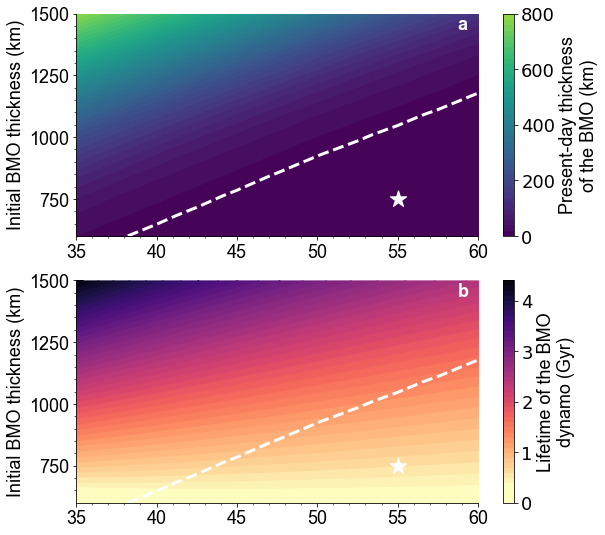

In [4]:
fig, axs = plt.subplots(2,1,figsize=(9,9))

fn = 'Arial'
fs = 18
lw = 3

ax1 = plt.subplot(211)

CP = plt.contourf(Qbmo0s/1e12, h0s/1e3, h_h0, 50, vmin=0, vmax=950)
plt.contour(Qbmo0s/1e12, h0s/1e3, h_h0, levels = [10], colors = ['w'], linewidths = [lw], linestyles='dashed')

plt.ylabel('Initial BMO thickness (km)',fontname=fn,fontsize=fs)
plt.xticks(np.linspace(35,60,6),fontname=fn, fontsize=fs)
plt.yticks(np.linspace(750,1500,4),fontname=fn, fontsize=fs)

plt.scatter(Qbmo0_ref/1e12,h0_ref/1e3,s=300,c='white',marker='*')

ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False) 
plt.minorticks_on()

cbar = fig.colorbar(CP, ticks=np.linspace(0,800,5))
cbar.ax.set_ylabel('Present-day thickness\nof the BMO (km)',fontname=fn,fontsize=fs)
cbar.ax.tick_params(labelsize=fs)

for c in CP.collections:
    c.set_edgecolor("face")
    
plt.text(0.95,0.93,'a',color='white',fontname=fn,fontsize=fs,fontweight='bold',transform=ax1.transAxes)



ax2 = plt.subplot(212)

CP2 = plt.contourf(Qbmo0s/1e12, h0s/1e3, td_h0, 50, vmin=0.34, vmax=4.5, cmap='magma_r')
plt.contour(Qbmo0s/1e12, h0s/1e3, h_h0, levels = [10], colors = ['w'], linewidths = [lw], linestyles='dashed')

plt.ylabel('Initial BMO thickness (km)',fontname=fn,fontsize=fs)
plt.xticks(np.linspace(35,60,6),fontname=fn, fontsize=fs)
plt.yticks(np.linspace(750,1500,4),fontname=fn, fontsize=fs)

plt.scatter(Qbmo0_ref/1e12,h0_ref/1e3,s=300,c='white',marker='*')

ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False) 
plt.minorticks_on()

cbar2 = fig.colorbar(CP2, ticks=np.linspace(0,4,5))

cbar2.ax.set_ylabel('Lifetime of the BMO\ndynamo (Gyr)',fontname=fn,fontsize=fs)
cbar2.ax.tick_params(labelsize=fs)

for c in CP2.collections:
    c.set_edgecolor("face")

plt.text(0.95,0.93,'b',color='white',fontname=fn,fontsize=fs,fontweight='bold',transform=ax2.transAxes)


plt.savefig('sensitiveEarth.pdf')

plt.show()